In [2]:
pip install geopandas mgwr pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\admin\appdata\local\programs\python\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric and removing NaNs/Infs...
Standardising data before PCA...


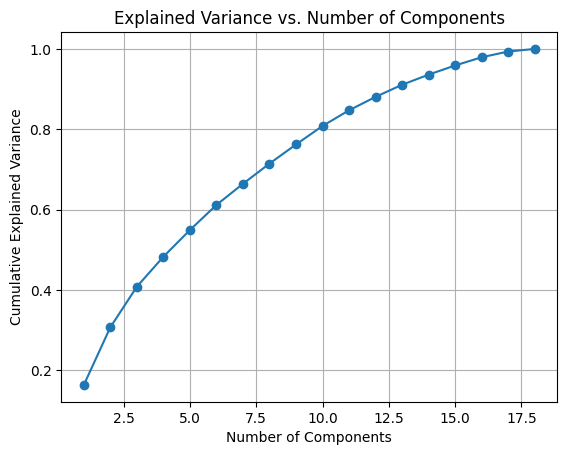

In [ ]:
# GWR PCA Test

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/cleaned_train.csv")
test_data = pd.read_csv("../../Data/cleaned_test.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [ # town_TE,flat_type_TE,flat_model_TE
    "month", "year", 
    "town_TE",
    "flat_type_TE",
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_TE",
    "lease_commence_date",
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Remove NaNs/Infs from dataset to prevent errors
print("Ensuring all features are numeric and removing NaNs/Infs...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Drop rows with NaNs/Infs
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Standardise features before PCA
print("Standardising data before PCA...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardise coordinates to avoid scale mismatch
coords_train = StandardScaler().fit_transform(coords_train)
coords_test = StandardScaler().fit_transform(coords_test)

pca_full = PCA().fit(X_train)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# # Apply PCA
# pca = PCA(n_components=0.90)  
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [ ]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load datasets
print("Loading datasets...")
train_data = pd.read_csv("../../Data/cleaned_train.csv")
test_data = pd.read_csv("../../Data/cleaned_test.csv")

target_variable = "resale_price"
model_columns = [ # town_TE,flat_type_TE,flat_model_TE
    "month", "year", 
    "town_TE",
    "flat_type_TE",
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_TE",
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers
print("Converting boolean columns...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Ensure numeric format and drop NaNs
print("Handling NaNs and infinite values...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

# Reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split data into spatial clusters
num_regions = 10  # Adjust based on memory availability
print(f"Clustering data into {num_regions} spatial regions...")
kmeans = KMeans(n_clusters=num_regions, random_state=42, n_init=10)
train_data['region'] = kmeans.fit_predict(train_data[['Latitude', 'Longitude']])
test_data['region'] = kmeans.predict(test_data[['Latitude', 'Longitude']])

# Prepare to store results
all_predictions = []
all_actuals = []

# Process each region separately
for region in range(num_regions):
    print(f"Processing region {region + 1}/{num_regions}...")
    
    # Filter region data
    region_train = train_data[train_data['region'] == region]
    region_test = test_data[test_data['region'] == region]
    
    # if len(region_train) < 500:  # Skip very small regions
    #     print(f"Skipping region {region}, too few data points.")
    #     continue

    coords_train = region_train[['Longitude', 'Latitude']].values
    coords_test = region_test[['Longitude', 'Latitude']].values
    X_train = region_train[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values
    X_test = region_test[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values
    y_train = region_train[target_variable].values.reshape(-1, 1)
    y_test = region_test[target_variable].values
    
    # Standardisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # PCA to reduce dimensions
    pca = PCA(n_components=0.90, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
    print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
    
    print(f"Region {region}: {len(coords_train)} samples remaining after cleaning.")
    
    if len(coords_train) < 10:
        print(f"Skipping region {region}, too few valid data points after cleaning.")
        continue
    
    
    # kernels = ['gaussian', 'bisquare', 'exponential']
    # adaptive_options = [True, False]

    kernel = 'exponential'
    fixed = True
    opt_bw=200

    # Train GWR model
    try:
        print("Verifying input shapes before GWR...")
        print(f"coords_train shape: {coords_train.shape}")
        print(f"Target variable shape: {y_train.shape}")
        print(f"X_train_pca shape: {X_train_pca.shape}")
        print(f"opt_bw: {opt_bw}")

        gwr_model = GWR(coords_train, y_train, X_train_pca, bw=200, kernel=kernel, fixed=fixed)
        gwr_results = gwr_model.fit()
        print("GWR Model Fitted Successfully!")
        # gwr_results.summary()
        
        # Predict on test data
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals).predictions.flatten()
        
        all_predictions.extend(y_pred)
        all_actuals.extend(y_test)
        
    except Exception as e:
        print(f"Error in region {region}: {str(e)}")
        continue

# Evaluate overall performance
mae = mean_absolute_error(all_actuals, all_predictions)
mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_actuals, all_predictions)
mape = np.mean(np.abs((np.array(all_actuals) - np.array(all_predictions)) / np.array(all_actuals))) * 100

print(f"kernal: {kernel}, fixed: {fixed}, opt_btw: {opt_bw}, MAE: {mae}, MAPE: {mape}, MSE: {mse}, RMSE: {rmse}, R² Score: {r2}")


Loading datasets...
Converting boolean columns...
Handling NaNs and infinite values...
Clustering data into 100 spatial regions...
Processing region 1/100...
Number of Principal Components Selected: 9
Explained Variance: 0.91
Region 0: 7051 samples remaining after cleaning.
Verifying input shapes before GWR...
coords_train shape: (7051, 2)
Target variable shape: (7051, 1)
X_train_pca shape: (7051, 9)
opt_bw: 200
GWR Model Fitted Successfully!
Error in region 0: GWR.predict() got an unexpected keyword argument 'fixed'
Processing region 2/100...
Number of Principal Components Selected: 5
Explained Variance: 0.97
Region 1: 200 samples remaining after cleaning.
Verifying input shapes before GWR...
coords_train shape: (200, 2)
Target variable shape: (200, 1)
X_train_pca shape: (200, 5)
opt_bw: 200
GWR Model Fitted Successfully!
Error in region 1: GWR.predict() got an unexpected keyword argument 'fixed'
Processing region 3/100...
Number of Principal Components Selected: 9
Explained Variance: